In [ ]:
import cv2
import os

def extract_frames(video_path, output_folder):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Open the video file
    video_capture = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        success, frame = video_capture.read()

        if not success:
            break

        # Save frame as an image in the output folder
        frame_name = f"frame_{frame_count}.jpg"
        frame_path = os.path.join(output_folder, frame_name)
        cv2.imwrite(frame_path, frame)

        frame_count += 1

    video_capture.release()
    print(f"Frames extracted: {frame_count}")

# Replace 'input_video.avi' with the path to your AVI file
video_file = '/Users/sharmas/Downloads/IITM/CV/CVProject/SOTA/CVProjectFinalcode/v_BasketballDunk_g04_c03.avi'

# Replace 'frames' with the desired output folder name
output_folder = 'frames'

extract_frames(video_file, output_folder)


# for C3d

In [ ]:
!pip install remotezip tqdm opencv-python einops -q
# Install TensorFlow 2.10
!pip install tensorflow==2.10.0 -q

In [1]:
import pandas as pd

In [2]:
!conda install nomkl -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done

## Package Plan ##

  environment location: /opt/homebrew/Caskroom/miniconda/base/envs/iitwork

  added / updated specs:
    - nomkl


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.12.12 |       hecd8cb5_0         127 KB
    ------------------------------------------------------------
                                           Total:         127 KB

The following packages will be UPDATED:

  ca-certificates                     2023.08.22-hecd8cb5_0 --> 2023.12.12-hecd8cb5_0



ca-certificates-2023 | 127 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [ ]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import keras
from keras import layers

## lOad and preprocess video

In [ ]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [ ]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

Create the training, validation, and test sets (train_ds, val_ds, and test_ds).

In [ ]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

## for homography

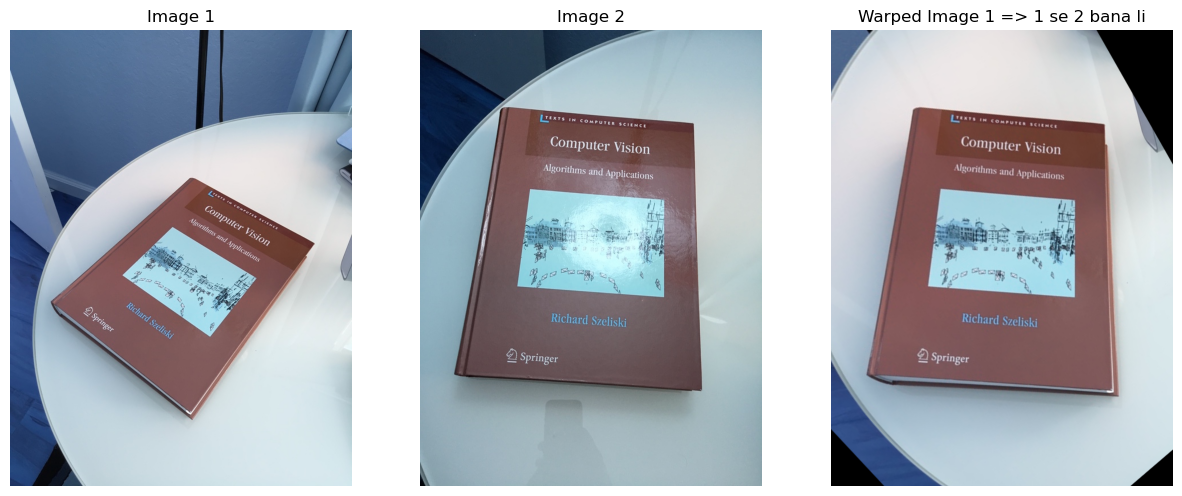

: 

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the images
image1 = cv2.imread('book1.jpg')  # Replace 'image1.jpg' with your first image path
image2 = cv2.imread('book2.jpg')  # Replace 'image2.jpg' with your second image path

# Detect keypoints and descriptors
sift = cv2.SIFT_create()
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# Match descriptors between the two images
bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Filter good matches using ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Extract matched keypoints
src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Calculate homography matrix
homography, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp image1 onto image2 using the calculated homography
height, width, _ = image2.shape
warped_image = cv2.warpPerspective(image1, homography, (width, height))

# Display the result with original image2 and warped image1 usin plt
plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.imshow(image1)
plt.title('Image 1')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(image2)
plt.title('Image 2')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(warped_image)
plt.title('Warped Image 1 => 1 se 2 bana li')
plt.axis('off')
plt.show()
# cv2.waitKey(0)
# cv2.destroyAllWindows()
